In [0]:
%pip install pydlm --quiet

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
import matplotlib.pyplot as plt
from pydlm import dlm, trend, seasonality, longSeason, autoReg
import pydlm.plot.dlmPlot as dlmPlot
%matplotlib inline

import scipy.stats
import numpy as np
import pandas as pd
import math
import time

from statsmodels.tsa import ar_model
from statsmodels.graphics.tsaplots import plot_pacf

In [0]:
display(dbutils.fs.ls("/FileStore/user/ryuta.yoshimatsu@databricks.com/bayesian_time_series/NAB/"))

path,name,size,modificationTime
dbfs:/FileStore/user/ryuta.yoshimatsu@databricks.com/bayesian_time_series/NAB/ambient_temperature_system_failure.csv,ambient_temperature_system_failure.csv,233321,1686283741000
dbfs:/FileStore/user/ryuta.yoshimatsu@databricks.com/bayesian_time_series/NAB/cpu_utilization_asg_misconfiguration.csv,cpu_utilization_asg_misconfiguration.csv,539274,1686283742000
dbfs:/FileStore/user/ryuta.yoshimatsu@databricks.com/bayesian_time_series/NAB/ec2_cpu_utilization_24ae8d.csv,ec2_cpu_utilization_24ae8d.csv,105367,1686282676000
dbfs:/FileStore/user/ryuta.yoshimatsu@databricks.com/bayesian_time_series/NAB/ec2_cpu_utilization_53ea38.csv,ec2_cpu_utilization_53ea38.csv,116041,1686282676000
dbfs:/FileStore/user/ryuta.yoshimatsu@databricks.com/bayesian_time_series/NAB/ec2_cpu_utilization_5f5533.csv,ec2_cpu_utilization_5f5533.csv,119229,1686282676000
dbfs:/FileStore/user/ryuta.yoshimatsu@databricks.com/bayesian_time_series/NAB/ec2_cpu_utilization_77c1ca.csv,ec2_cpu_utilization_77c1ca.csv,106007,1686282676000
dbfs:/FileStore/user/ryuta.yoshimatsu@databricks.com/bayesian_time_series/NAB/ec2_cpu_utilization_825cc2.csv,ec2_cpu_utilization_825cc2.csv,113675,1686282677000
dbfs:/FileStore/user/ryuta.yoshimatsu@databricks.com/bayesian_time_series/NAB/ec2_cpu_utilization_ac20cd.csv,ec2_cpu_utilization_ac20cd.csv,116980,1686282677000
dbfs:/FileStore/user/ryuta.yoshimatsu@databricks.com/bayesian_time_series/NAB/ec2_cpu_utilization_c6585a.csv,ec2_cpu_utilization_c6585a.csv,104962,1686282677000
dbfs:/FileStore/user/ryuta.yoshimatsu@databricks.com/bayesian_time_series/NAB/ec2_cpu_utilization_fe7f93.csv,ec2_cpu_utilization_fe7f93.csv,115788,1686282677000


In [0]:
path = "dbfs:/FileStore/user/ryuta.yoshimatsu@databricks.com/bayesian_time_series/NAB/nyc_taxi.csv"

In [0]:
time_series = (spark.read
  .format("csv")
  .option("delimiter", ",")
  .option("header", True)
  .option ("inferSchema", True)
  .load(path)
).toPandas()

display(time_series)

timestamp,value
2014-07-01T00:00:00.000+0000,10844
2014-07-01T00:30:00.000+0000,8127
2014-07-01T01:00:00.000+0000,6210
2014-07-01T01:30:00.000+0000,4656
2014-07-01T02:00:00.000+0000,3820
2014-07-01T02:30:00.000+0000,2873
2014-07-01T03:00:00.000+0000,2369
2014-07-01T03:30:00.000+0000,2064
2014-07-01T04:00:00.000+0000,2221
2014-07-01T04:30:00.000+0000,2158


Databricks visualization. Run in Databricks to view.

In [0]:
#time_series = time_series.reset_index()
time_series_hist = time_series[time_series["timestamp"] < "2015-01-15"].reset_index()
time_series_fut = time_series[time_series["timestamp"] >= "2015-01-15"].reset_index()

In [0]:
time_series_hist_l = list(time_series_hist["value"])
time_series_fut_l = list(time_series_fut["value"])
time_series_l = list(time_series["value"])

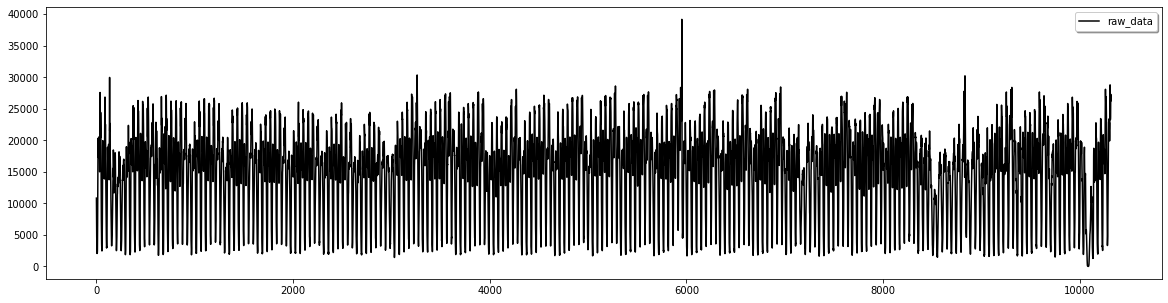

In [0]:
# Plot the raw data
plt.rcParams['figure.figsize'] = [20, 5]
dlmPlot.plotData(range(len(time_series_l)),
                 time_series_l,
                 showDataPoint=False,
                 label='raw_data')
plt.legend(loc='best', shadow=True)
plt.show()

In [0]:
# Check for the best AR order
#search = ar_model.ar_select_order(endog=time_series_hist_l, maxlag=48, ic="aic", seasonal=True, period=48)
#search.ar_lags

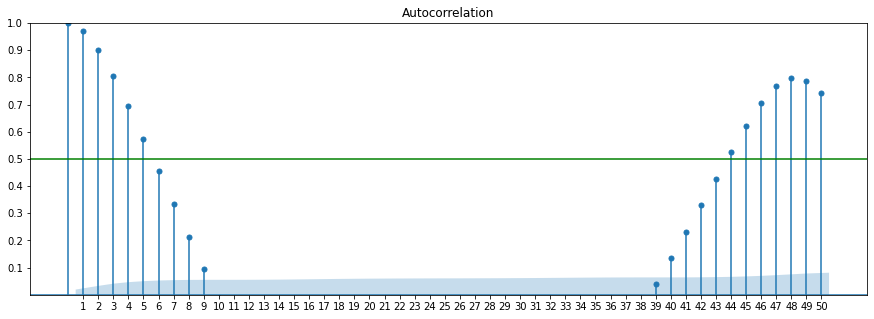

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np

fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(time_series_l, lags=50, ax=ax)
plt.ylim([0,1])
plt.yticks(np.arange(0.1, 1.1, 0.1))
plt.xticks(np.arange(1, 51, 1))
plt.axhline(y=0.5, color="green")
plt.show()

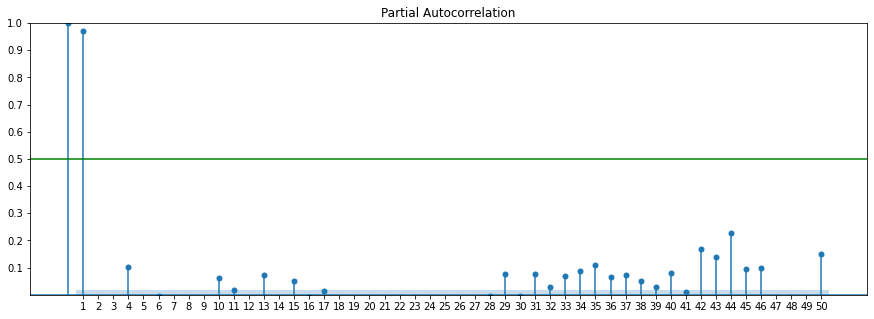

In [0]:
fig, ax = plt.subplots(figsize=(15,5))
plot_pacf(time_series_l, lags=50, ax=ax)
plt.ylim([0,1])
plt.yticks(np.arange(0.1, 1.1, 0.1))
plt.xticks(np.arange(1, 51, 1))
plt.axhline(y=0.5, color="green")
plt.show()

In [0]:
# Linear trend
linear_trend = trend(degree=2, discount=1, name='locally_linear_trend')

# Seasonality
seasonal_d = seasonality(period=48, discount=1, name='seasonal_d')
seasonal_w = longSeason(period=48*7, stay=48*7, discount=1, data=time_series_l, name='seasonal_w')

# Autoregression
ar = autoReg(degree=1, discount=1, name='ar')

# Model
simple_dlm = dlm(time_series_l) + linear_trend + ar + seasonal_d + seasonal_w

simple_dlm.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [0]:
#simple_dlm.tune()
#simple_dlm.fit()

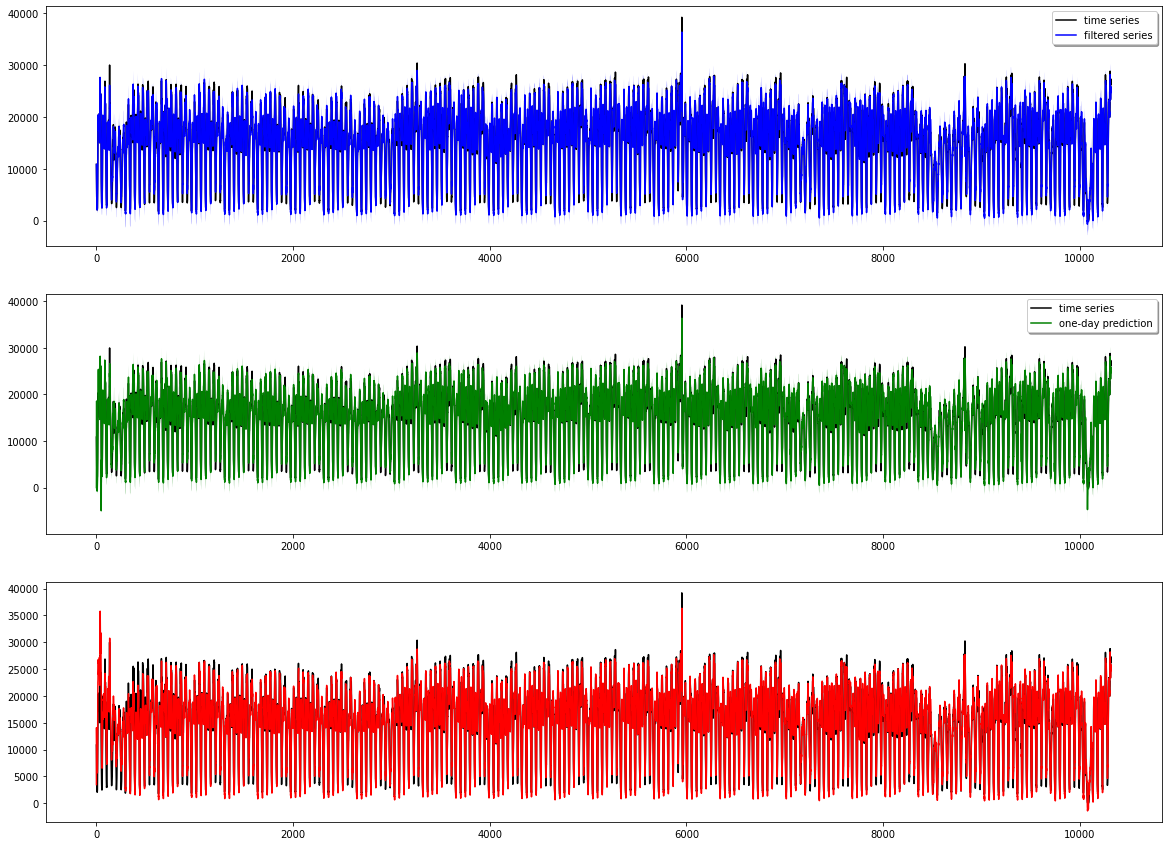

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
File <command-929143988207952>:5
      3 simple_dlm.resetPlotOptions()
      4 simple_dlm.turnOff('data points')
----> 5 simple_dlm.plot()

File /local_disk0/.ephemeral_nfs/envs/pythonEnv-22826cc5-47cf-4cbe-87b2-ffd16d3e2def/lib/python3.9/site-packages/pydlm/plot/dlmPlotMod.py:204, in dlmPlotModule.plot(self, name)
    198         dlmPlot.plotInOneFigure(time=time,
    199                                 data=self.data,
    200                                 result=self.result,
    201                                 options=self.options)
    202     # otherwise, we plot in multiple figures
    203     else:
--> 204         dlmPlot.plotInMultipleFigure(time=time,
    205                                      data=self.data,
    206                                      result=self.result,
    207                                      opti

In [0]:
# Plot the fitted results
plt.rcParams['figure.figsize'] = [20, 15]
simple_dlm.resetPlotOptions()
simple_dlm.turnOff('data points')
simple_dlm.plot()

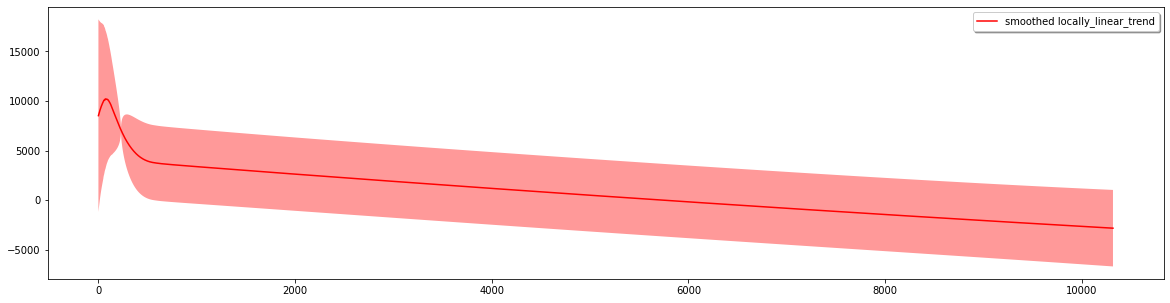

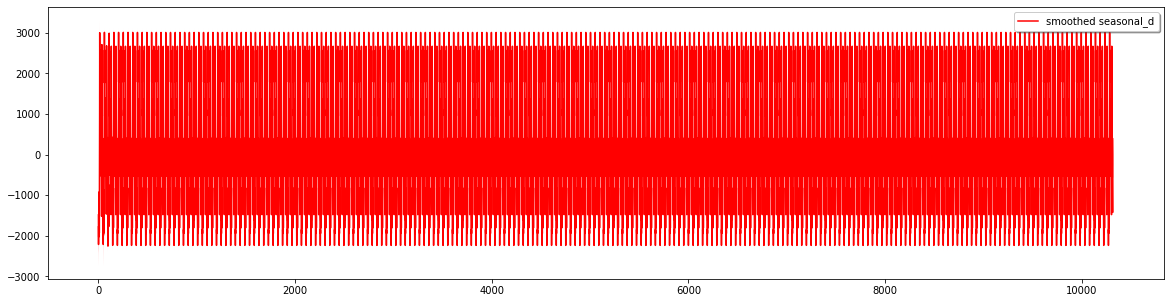

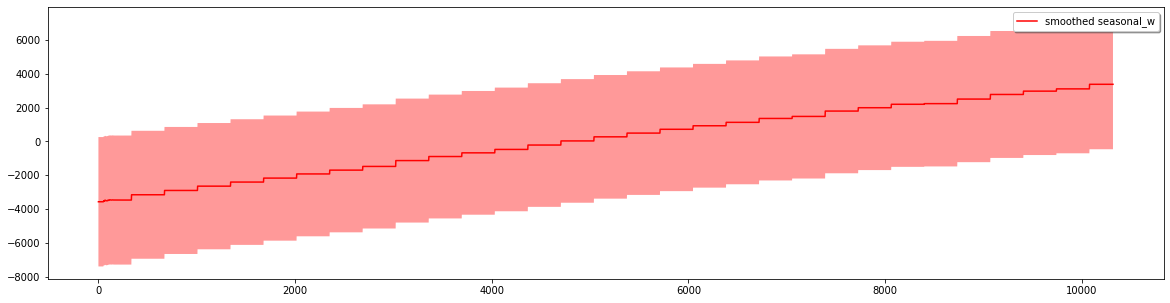

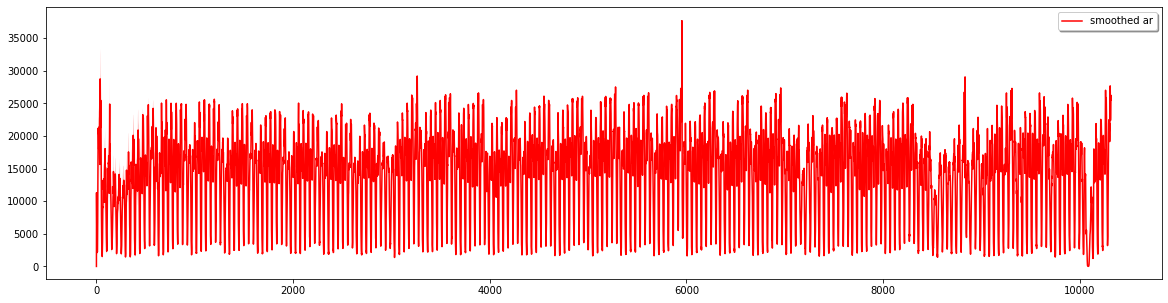

In [0]:
# Plot each component (attribution)
plt.rcParams['figure.figsize'] = [20, 5]
simple_dlm.resetPlotOptions()
simple_dlm.turnOff('predict plot')
simple_dlm.turnOff('filtered plot')
simple_dlm.plot('locally_linear_trend')
simple_dlm.plot('seasonal_d')
simple_dlm.plot('seasonal_w')
simple_dlm.plot('ar')

In [0]:
# get the predict results
predictedMean = simple_dlm.getMean(filterType='predict')
predictedVar = simple_dlm.getVar(filterType='predict')
predictedCI = simple_dlm.getInterval(filterType='predict')

In [0]:
probabilities = []
above = False
for i in range(len(time_series_l)):
  if time_series_l[i] < predictedMean[i]:
    probability = scipy.stats.norm(predictedMean[i], np.sqrt(predictedVar[i])).cdf(time_series_l[i]) * 2.0
    above = False
  else:
    probability = scipy.stats.norm(predictedMean[i], np.sqrt(predictedVar[i])).sf(time_series_l[i]) * 2.0
    above = True
  neg_log_p = -1 * math.log(probability) if probability!=0 else None
  probabilities.append([i, predictedMean[i], time_series_l[i], np.sqrt(predictedVar[i]), probability, neg_log_p, above])

In [0]:
df = pd.DataFrame(probabilities, columns=["index", "predicted_mean", "observation", "sd", "probability", "negative_log_p", "above"])

In [0]:
anomalies = df[df["probability"] < 0.001].merge(time_series.reset_index(), how='inner', on="index")
anomalies.head()

,index,predicted_mean,observation,sd,probability,negative_log_p,above,timestamp,value
0,0,0.000000,10844,22.336443,0.000000e+00,NaN,True,2014-07-01 00:00:00,10844
1,48,26085.292303,13370,1290.148164,6.477429e-23,51.091133,False,2014-07-02 00:00:00,13370
2,49,-4986.598936,9945,1927.645627,9.481086e-15,32.289477,True,2014-07-02 00:30:00,9945
3,83,18829.536184,21919,790.820087,9.358136e-05,9.276679,True,2014-07-02 17:30:00,21919
4,85,27382.442006,24512,847.142960,7.030686e-04,7.260056,False,2014-07-02 18:30:00,24512


Out[33]: [<matplotlib.lines.Line2D at 0x7f5dccdf1520>]

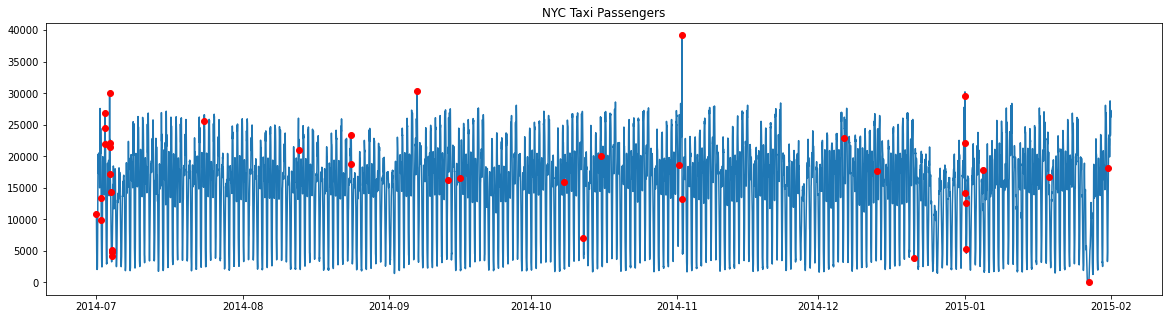

In [0]:
# Plot the time series and mark the observations with below 0.001 predictive probability 
plt.rcParams['figure.figsize'] = [20, 5]
plt.title("NYC Taxi Passengers")
plt.plot(time_series.timestamp, time_series.value)
plt.plot(anomalies.timestamp, anomalies.observation, 'ro')

Out[32]: [<matplotlib.lines.Line2D at 0x7f5dcd865fa0>]

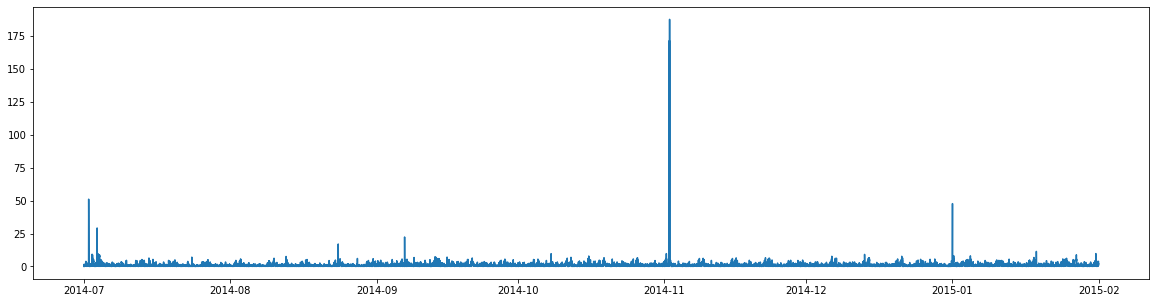

In [0]:
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(time_series.timestamp, df.negative_log_p)

## Online filtering

In [0]:
online_dlm = simple_dlm

# to run GUI event loop
plt.ion()
 
# here we are creating sub plots
figure, ax = plt.subplots(figsize=(20, 7.5))

line1, = ax.plot(df.timestamp, df.observation)
line2, = ax.plot(anomalies.timestamp, anomalies.observation, 'ro')
 
# setting title
plt.title("NYC Taxi Passengers", fontsize=20)
 
# setting x-axis label and y-axis label

for t in range(0, len(time_series_fut_l)):

  online_dlm.append([time_series_fut_l[t]])
  online_dlm.fitForwardFilter(useRollingWindow=True, windowLength=48*3)

  # get the online predict results
  predictedMean_fut = online_dlm.getMean(filterType='predict')
  predictedVar_fut = online_dlm.getVar(filterType='predict')
  predictedCI_fut = online_dlm.getInterval(filterType='predict')

  if time_series_fut_l[t] < predictedMean_fut[-1]:
    probability = scipy.stats.norm(predictedMean_fut[-1], np.sqrt(predictedVar_fut[-1])).cdf(time_series_fut_l[t]) * 2.0
    above = False
  else:
    probability = scipy.stats.norm(predictedMean_fut[-1], np.sqrt(predictedVar_fut[-1])).sf(time_series_fut_l[t]) * 2.0
    above = True

  neg_log_p = -1 * math.log(probability) if probability!=0 else None
  probabilities.append(
    [
      len(time_series_hist_l) + t,
      predictedMean_fut[-1],
      time_series_fut_l[t],
      np.sqrt(predictedVar_fut[-1]),
      probability,
      neg_log_p,
      above
    ]
  )

  df = pd.DataFrame(probabilities, columns=["index", "predicted_mean", "observation", "sd", "probability", "negative_log_p", "above"])
  df = df.merge(time_series.reset_index(), how='inner', on="index")

  anomalies = df[df["probability"] < 0.001].merge(time_series.reset_index(), how='inner', on="index", suffixes=('', '_remove'))
  anomalies.drop([i for i in anomalies.columns if 'remove' in i], axis=1, inplace=True)

  # Plot the time series and mark the observations with below 0.001 predictive probability 
  # updating data values
  line1.set_xdata(df.timestamp)
  line1.set_ydata(df.observation)

  line2.set_xdata(anomalies.timestamp)
  line2.set_ydata(anomalies.observation)

  # drawing updated values
  figure.canvas.draw()

  # This will run the GUI event
  # loop until all UI events
  # currently waiting have been processed
  figure.canvas.flush_events()
  #time.sleep(0.1)

In [0]:
# generating random data values
x = np.linspace(1, 1000, 5000)
y = np.random.randint(1, 1000, 5000)
 
# enable interactive mode
plt.ion()
 
# creating subplot and figure
fig = plt.figure()
ax = fig.add_subplot(111)
line1, = ax.plot(x, y)
 
# setting labels
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Updating plot...")
 
# looping
for _ in range(50):
   
    # updating the value of x and y
    line1.set_xdata(x*_)
    line1.set_ydata(y)
 
    # re-drawing the figure
    fig.canvas.draw()
     
    # to flush the GUI events
    fig.canvas.flush_events()
    time.sleep(1)